# Unbuffered backtest

In [1]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf   # falls back to sample cov below

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df = df.sort_values(by=['datetime'])
first_idx = df['fundingRate'].first_valid_index() # important to see when stuff began trading
df = df.loc[first_idx:]
df = df[df.datetime>'2021-01-01']
df = df[df.datetime<'2025-01-01']

HORIZON = 10

In [2]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume'],
      dtype='object')

In [ ]:
import signals

# Signal generation
def compute_signal(df: pd.DataFrame) -> pd.DataFrame:
	df = signals._compute_buy_volume_ratio(df, 'buy_volume_ratio', 32)
	df = signals._compute_bolmom(df, 'bolmom', 32)
	df = signals._compute_funding_volatility(df, 'funding_volatility', 2)
	df = signals._compute_ls_ratio(df, 'ls_ratio', 8)

	return df

# ── Universe filtering ──────────────────────────────────────────────────────
def filter_universe(df: pd.DataFrame) -> pd.DataFrame:
	"""
	Filter out illiquids and newly listed coins.
	"""

	df = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume 
	df = df[df.days_since_listing >= 90] # at least 90 days since listing (need data for risk estimate)
	return df

# Data preparation
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
	df = df.sort_values(['datetime', 'symbol'])
	df['return'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change())

	# 1) Calculate volatility
	df['vol_expanding_window'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .expanding(min_periods=30)
					  .std())
	)
	df['vol_ewm'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .ewm(span=30, adjust=False, min_periods=30)
					  .std())
	)
	df['volatility'] = (
		df['vol_expanding_window'] * 0.25 +
		df['vol_ewm'] * 0.75
	)

	# 2) filter universe
	df['dollar_volume'] = df['close'] * df['volume']
	df['dollar_volume_slowed'] = (
		df.groupby('symbol')['dollar_volume']
		  .transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['dv_rank'] = (
		df.groupby('datetime')['dollar_volume_slowed']
		  .rank(method='first', ascending=False)
	)
	df['dv_decile'] = df.groupby('datetime')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['mc_rank'] = (
		df.groupby('datetime')['market_cap_slowed']
			.rank(method='first', ascending=False)
	)
	df['mc_decile'] = df.groupby('datetime')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	# 1) how many observations each symbol has accumulated up to *and incl.* the row
	df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

	return df

# TODO: Add funding returns to target 
def add_prediction_target(df: pd.DataFrame) -> pd.DataFrame:
	df = df.copy()
	df = df.sort_values(['datetime'])
	# demean within each date
	df['target'] = df.groupby('datetime')['fwd_return'].transform(lambda x: x - x.mean())
	return df.drop(columns=['forward_price', 'fwd_return'])

# Caclculate before uni filtering
df['forward_price'] = df.groupby('symbol')['close'].shift(-HORIZON)
df['fwd_return'] = (df['forward_price'] - df['close']) / df['close']

print("Preparing data...")
df = prepare_data(df)

print("Computing signal...")
df = compute_signal(df)

print("Filtering universe...")
df = filter_universe(df)

print("Adding prediction target...")
df = add_prediction_target(df)

df


Preparing data...
Computing signal...
Computing buy volume ratio signal...
Computing Bollinger Band momentum signal...
Computing funding rate volatility signal...
Computing long–short ratio signal...
Filtering universe...
Adding prediction target...


,symbol,datetime,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,dv_decile,market_cap_slowed,mc_rank,mc_decile,days_since_listing,buy_volume_ratio,bolmom,funding_volatility,ls_ratio_ewm,target
20311,1INCH,2021-04-01,4.344400,4.533900,4.253700,4.460600,14490755.0,NaN,0.003538,NaN,...,7.0,NaN,NaN,NaN,90,0.462047,0.195358,0.000886,6.040379,0.099445
20381,SNX,2021-04-01,17.693000,19.431000,17.632000,19.206000,2782391.5,2.411015e+09,0.004446,NaN,...,3.0,2.347651e+09,24.0,7.0,90,0.472469,0.076185,0.000475,3.572030,-0.183622
20380,SKL,2021-04-01,0.752120,0.824600,0.720000,0.816680,106781335.0,4.606508e+08,0.004734,NaN,...,6.0,2.748150e+08,54.0,2.0,90,0.476875,0.492446,0.000698,3.218522,-0.319714
20376,RUNE,2021-04-01,7.959600,8.955000,7.957900,8.340300,8303806.0,0.000000e+00,0.002288,NaN,...,2.0,0.000000e+00,66.0,1.0,90,0.474938,1.000000,0.000437,1.919459,0.149518
20375,RSR,2021-04-01,0.090032,0.091795,0.084801,0.088243,467587452.0,3.706845e+08,0.004858,NaN,...,5.0,2.826469e+08,51.0,3.0,90,0.468753,0.396238,0.001357,3.720754,-0.195028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262969,EGLD,2024-12-31,34.301000,35.179000,33.026000,33.437000,415161.8,4.518378e+08,0.000300,9.757355e+06,...,5.0,5.006956e+08,92.0,7.0,1460,0.478517,-0.333153,0.000004,2.226191,NaN
262968,EDU,2024-12-31,0.530400,0.545700,0.518000,0.525700,10433287.0,NaN,0.000300,5.918918e+06,...,3.0,NaN,NaN,NaN,612,0.475265,-0.343115,0.000022,2.842960,NaN
262967,DYM,2024-12-31,1.356100,1.398800,1.300500,1.322600,5957093.4,2.548972e+08,0.000300,7.250934e+06,...,5.0,3.405120e+08,116.0,6.0,329,0.474241,-0.486062,0.000002,3.718615,NaN
262939,CHR,2024-12-31,0.238900,0.241500,0.222700,0.232300,58700697.0,1.934000e+08,0.000283,4.443076e+06,...,4.0,2.075113e+08,148.0,5.0,1391,0.477325,-0.317016,0.000030,2.258553,NaN


# OLS forecast


In [15]:
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import utils


def add_interactions(df, feature_cols, interactions, inter_names):
    """
    Add interaction columns a*b to df inplace.
    Returns updated DataFrame with main effects + interactions.
    """
    X_df = df[feature_cols].copy()
    for (a, b), name in zip(interactions, inter_names):
        if a in X_df.columns and b in X_df.columns:
            X_df[name] = X_df[a] * X_df[b]
    return X_df


def purged_blocked_cv_r2(
    train_df,                      # MultiIndex (datetime, symbol)
    feature_cols,                  # main-effect feature names
    target_col,
    horizon,
    interactions=None,             # list of tuples [('a','b'), ...]
    n_splits=5,
    min_train_days=10,
    embargo_by="steps"             # "steps" (bars) or "days"
):
    """
    Forward-chaining, purged CV (no standardization).
    - Use raw main effects
    - Add interactions as a*b on train and test
    - Embargo 'horizon' (by steps or days) before the test block
    - Fit OLS with intercept; score R^2 out-of-sample
    """
    if interactions is None:
        interactions = []
    inter_names = [f"{a}*{b}" for (a, b) in interactions]

    dates = train_df.index.get_level_values(0).unique().sort_values()
    if len(dates) < n_splits + 1:
        return float("nan")

    blocks = np.array_split(dates, n_splits)
    r2s = []

    for b in range(1, n_splits):  # need past to train on
        test_dates = blocks[b]
        test_start = test_dates[0]

        # Embargo: remove last 'horizon' worth of training dates
        if embargo_by == "days":
            cutoff = test_start - pd.Timedelta(days=horizon)
            train_dates = dates[dates < cutoff]
        else:  # "steps" == bars
            before = dates[dates < test_start]
            embargo_n = min(horizon, len(before))
            train_dates = before[:-embargo_n] if embargo_n > 0 else before

        if len(train_dates) < min_train_days:
            continue

        tr = train_df.loc[train_dates]
        te = train_df.loc[test_dates]

        # Features with interactions
        Xtr_df = add_interactions(tr, feature_cols, interactions, inter_names)
        Xte_df = add_interactions(te, feature_cols, interactions, inter_names)

        # Drop rows with any NaN in X or y
        tr_join = pd.concat([Xtr_df, tr[[target_col]]], axis=1).dropna()
        te_join = pd.concat([Xte_df, te[[target_col]]], axis=1).dropna()
        if tr_join.empty or te_join.empty:
            continue

        Xtr = np.column_stack([np.ones(len(tr_join)), tr_join[Xtr_df.columns].values])
        Xte = np.column_stack([np.ones(len(te_join)), te_join[Xte_df.columns].values])
        ytr = tr_join[target_col].values
        yte = te_join[target_col].values

        # Fit & score
        beta = np.linalg.lstsq(Xtr, ytr, rcond=None)[0]
        yhat = Xte @ beta
        r2s.append(r2_score(yte, yhat))

    return float(np.nanmean(r2s)) if r2s else float("nan")


def pivot_features(df, feature_cols, target_col):
    """Pivot long-form df into wide format dict of feature DataFrames + target DataFrame."""
    Xs = {f: df.pivot(index="datetime", columns="symbol", values=f) for f in feature_cols}
    Y = df.pivot(index="datetime", columns="symbol", values=target_col)
    return Xs, Y


def build_design_matrix(train, feature_cols, interactions, inter_names):
    """Build design matrix with intercept, main effects, and interactions."""
    X_df = add_interactions(train, feature_cols, interactions, inter_names)
    X_df = X_df.copy()
    X_df.insert(0, 'intercept', 1.0)
    return X_df.values, X_df.columns.tolist()


def fit_ols(Xmat, yvec):
    """Fit plain OLS via lstsq."""
    return np.linalg.lstsq(Xmat, yvec, rcond=None)[0]


def build_today_features(Xs, di, cols, feature_cols, interactions, inter_names, beta_cols):
    """Build today's design matrix for prediction."""
    X_today_df = pd.DataFrame(index=cols, dtype=float)
    for f in feature_cols:
        X_today_df[f] = Xs[f].iloc[di].reindex(cols).values
    X_today_df = add_interactions(X_today_df, feature_cols, interactions, inter_names)
    X_today_df.insert(0, 'intercept', 1.0)
    return X_today_df[beta_cols].values

def standardize_features(df, feature_cols, interactions, inter_names):
    """
    Standardize predictors in df.
    Returns standardized design matrix (with intercept), column names,
    and the (mean, std) dictionaries used for transformation.
    """
    X_df = add_interactions(df, feature_cols, interactions, inter_names)
    mu = X_df.mean()
    sigma = X_df.std(ddof=0).replace(0, 1.0)  # avoid div by 0
    X_std = (X_df - mu) / sigma
    X_std.insert(0, "intercept", 1.0)
    return X_std.values, ["intercept"] + list(X_df.columns), mu, sigma


def apply_standardization(X_df, mu, sigma, beta_cols):
    """
    Apply a given mean/std transform to new data (for prediction).
    """
    X_std = (X_df - mu) / sigma
    X_std.insert(0, "intercept", 1.0)
    return X_std[beta_cols].values

def walkforward_cs_ols(df,
                       feature_cols,
                       lookback,
                       horizon,
                       target_col="target",
                       interactions=None,
                       window_type="rolling",   # "rolling" | "expanding" | "exponential"
                       decay=0.94,              # for exponential weighting
                       verbose=False):
    """
    Walk-forward cross-sectional OLS with feature standardization.
    Standardizes predictors using only training data, then applies
    the same mean/std transform when predicting.

    Parameters
    ----------
    df : pd.DataFrame (MultiIndex [datetime, symbol])
    feature_cols : list[str]
        Names of main-effect features.
    lookback : int
        Lookback length for rolling window.
    horizon : int
        Forecast horizon (also embargo length).
    target_col : str
        Column name of target variable.
    interactions : list[tuple], optional
        List of interaction terms [('a','b'), ...].
    window_type : {"rolling", "expanding", "exponential"}
        - rolling: fixed-length lookback
        - expanding: grows from start
        - exponential: all past, downweighted with decay
    decay : float
        Decay factor for exponential weighting (0<decay<1).
    verbose : bool
        Print progress.
    """
    if interactions is None:
        interactions = []

    # --- Precompute pivots
    Xs, Y = pivot_features(df, feature_cols, target_col)
    idx, cols = Y.index, Y.columns

    inter_names = [f"{a}*{b}" for (a, b) in interactions]
    beta_cols = ["intercept"] + list(feature_cols) + inter_names
    vif_cols = list(feature_cols) + inter_names

    # outputs
    F = pd.DataFrame(index=idx, columns=cols, dtype=float)
    B = pd.DataFrame(index=idx, columns=beta_cols, dtype=float)
    CV_R2 = pd.Series(index=idx, dtype=float)
    V = pd.DataFrame(index=idx, columns=vif_cols, dtype=float)

    # --- Walk forward
    for di in range(max(lookback, horizon), len(idx)):
        # Define training window
        if window_type == "rolling":
            start, end = di - lookback, di - horizon + 1
        elif window_type in ("expanding", "exponential"):
            start, end = 0, di - horizon + 1
        else:
            raise ValueError("window_type must be 'rolling', 'expanding', or 'exponential'")

        if end <= start:
            continue

        train_dates = idx[start:end]
        stacked_feats = [Xs[f].iloc[start:end].stack().rename(f) for f in feature_cols]
        ys = Y.iloc[start:end].stack().rename(target_col)
        train = pd.concat(stacked_feats + [ys], axis=1).dropna()
        if train.empty:
            continue

        if verbose:
            print(f"Forecast date {idx[di].date()} "
                  f"→ training window {train_dates[0].date()} to {train_dates[-1].date()} "
                  f"(n={len(train)})")

        # --- Standardize predictors
        Xmat, Xcols, mu, sigma = standardize_features(
            train[feature_cols], feature_cols, interactions, inter_names
        )
        yvec = train[target_col].values

        # Apply exponential weighting
        if window_type == "exponential":
            n_obs = len(yvec)
            weights = decay ** np.arange(n_obs - 1, -1, -1)  # newest = weight 1
            W = np.sqrt(weights)[:, None]
            Xmat = Xmat * W
            yvec = yvec * np.sqrt(weights)

        # CV metric (still uses rolling purge CV, no standardization inside CV)
        CV_R2.iloc[di] = purged_blocked_cv_r2(
            train,
            feature_cols=feature_cols,
            target_col=target_col,
            horizon=horizon,
            interactions=interactions,
            n_splits=5,
            min_train_days=10,
            embargo_by="steps"
        )

        # VIF (computed on standardized X)
        try:
            V.loc[idx[di], vif_cols] = utils.calculate_vif(Xmat, vif_cols)
        except Exception:
            pass

        # --- Fit OLS
        beta = fit_ols(Xmat, yvec)
        B.loc[idx[di], beta_cols] = beta

        # --- Predict today's cross-section
        X_today_df = pd.DataFrame(index=cols, dtype=float)
        for f in feature_cols:
            X_today_df[f] = Xs[f].iloc[di].reindex(cols).values
        X_today_df = add_interactions(X_today_df, feature_cols, interactions, inter_names)

        X_today = apply_standardization(X_today_df, mu, sigma, beta_cols)
        F.iloc[di] = X_today @ beta

    return F, B, CV_R2, V


# Example run
forecast, betas, cv_r2, vif_df = walkforward_cs_ols(
    df,
    feature_cols=["bolmom", "dv_decile"],
    interactions=[("bolmom", "dv_decile")],
    target_col="target",
    lookback=45,
    horizon=HORIZON,
    verbose=True,
    window_type="expanding",
    decay=0.98
)


Forecast date 2021-05-16 → training window 2021-04-01 to 2021-05-06 (n=2598)
Forecast date 2021-05-17 → training window 2021-04-01 to 2021-05-07 (n=2672)
Forecast date 2021-05-18 → training window 2021-04-01 to 2021-05-08 (n=2746)
Forecast date 2021-05-19 → training window 2021-04-01 to 2021-05-09 (n=2820)
Forecast date 2021-05-20 → training window 2021-04-01 to 2021-05-10 (n=2894)
Forecast date 2021-05-21 → training window 2021-04-01 to 2021-05-11 (n=2968)
Forecast date 2021-05-22 → training window 2021-04-01 to 2021-05-12 (n=3042)
Forecast date 2021-05-23 → training window 2021-04-01 to 2021-05-13 (n=3116)
Forecast date 2021-05-24 → training window 2021-04-01 to 2021-05-14 (n=3190)
Forecast date 2021-05-25 → training window 2021-04-01 to 2021-05-15 (n=3264)
Forecast date 2021-05-26 → training window 2021-04-01 to 2021-05-16 (n=3338)
Forecast date 2021-05-27 → training window 2021-04-01 to 2021-05-17 (n=3412)
Forecast date 2021-05-28 → training window 2021-04-01 to 2021-05-18 (n=3487)

# Forecast Model Betas

intercept           0.002270
bolmom             -0.013211
dv_decile          -0.000510
bolmom*dv_decile    0.003043
dtype: float64

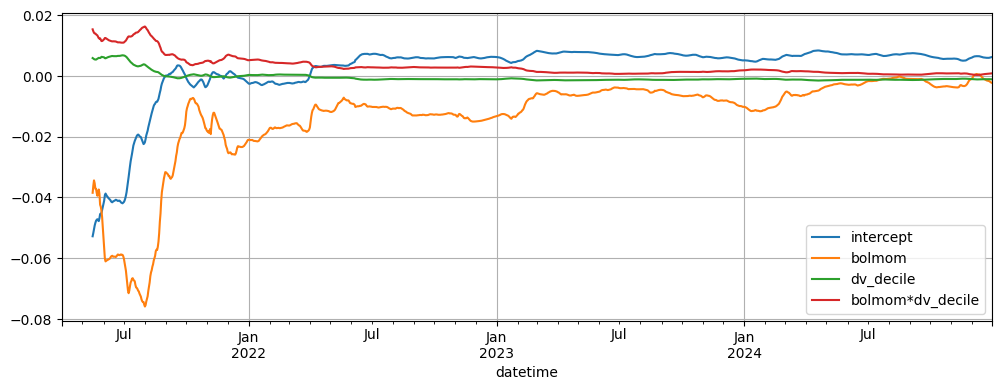

In [5]:
betas.plot(figsize=(12,4), grid=True)
betas.mean()

# CV r2 vs Realized R2

Realized R2 leads by ~2 weeks. This makes sense because CV R2 is using a rolling window, but realized is instant feedback.

Max correlation at lag 16 days, corr = 0.504

In [6]:
# # Join forecasts back to original df
# df = df.merge(forecast.stack().rename('forecast'), left_on=['datetime', 'symbol'], right_index=True)

# Drop existing 'forecast' column from df to avoid conflicts
if 'forecast' in df.columns:
    df = df.drop(columns='forecast')

# Join forecasts back to original df
df = df.merge(forecast.stack().rename('forecast'), 
              left_on=['datetime', 'symbol'], 
              right_index=True, 
              how='left')

C:\Users\itataurov\AppData\Local\Temp\ipykernel_32572\3922847037.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: r2_score(g['target'], g['forecast'])


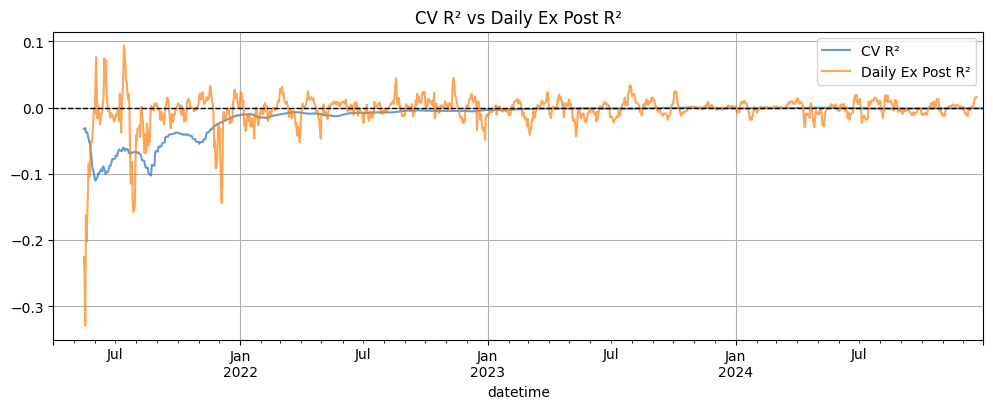

          Metric    Mean  Median
           CV R² -0.0124 -0.0017
Daily Ex Post R² -0.0043 -0.0007


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# --- Daily realized R² ---
daily_r2 = (
    df.dropna(subset=['forecast','target'])
      .groupby('datetime')
      .apply(lambda g: r2_score(g['target'], g['forecast'])
             if len(g) > 1 else np.nan)
)

# --- Plot CV R² vs Daily R² together ---
fig, ax = plt.subplots(figsize=(12,4))
cv_r2.plot(ax=ax, label="CV R²", alpha=0.7)
daily_r2.plot(ax=ax, label="Daily Ex Post R²", alpha=0.7)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.grid(True)
ax.set_title("CV R² vs Daily Ex Post R²")
ax.legend()
plt.show()

summary = pd.DataFrame({
    "Metric": ["CV R²", "Daily Ex Post R²"],
    "Mean": [cv_r2.mean(), daily_r2.mean()],
    "Median": [cv_r2.median(), daily_r2.median()]
})

print(summary.to_string(index=False, float_format="{:.4f}".format))


# VIF's

Text(0.5, 1.0, 'VIF Over Time')

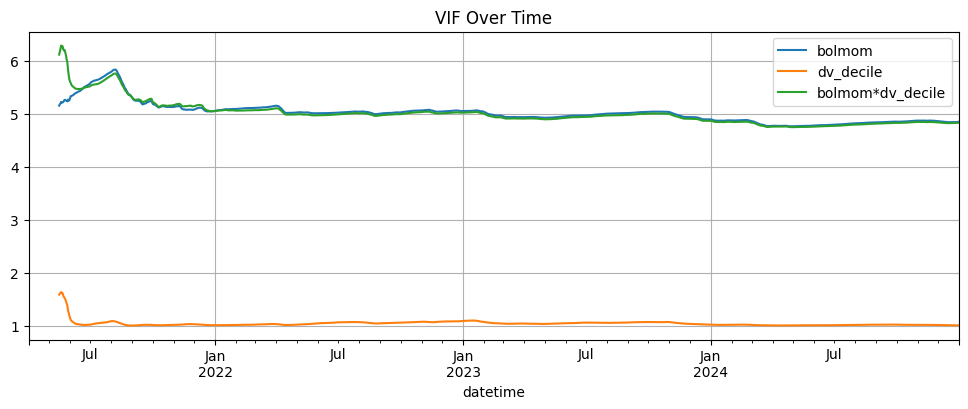

In [8]:
vif_df.plot(figsize=(12,4), grid=True)
plt.title("VIF Over Time")


In [9]:
# Pivot for backtest inputs
def pivot_data(df: pd.DataFrame):
	forecast = df.pivot(index='datetime', columns='symbol', values='forecast')
	returns = df.pivot(index='datetime', columns='symbol', values='return')
	funding = df.pivot(index='datetime', columns='symbol', values='fundingRate')
	volatility = df.pivot(index='datetime', columns='symbol', values='volatility')

	return forecast, returns, funding, volatility

forecast, returns, funding, volatility = pivot_data(df)

In [10]:
def compute_weights(alpha_forecast: pd.DataFrame,
                    lag: bool = True,
                    inertia: float = 0.0,   # 0 ≤ inertia < 1
                    l2_shrink: float = 0.0  # ≥ 0, strength of shrinkage
                   ) -> pd.DataFrame:
    """
    Convert a cross-sectional alpha signal into dollar-neutral weights,
    with optional inertia and L2 shrinkage.

    Parameters
    ----------
    alpha_forecast : DataFrame  (index = timestamp, columns = symbol)
    lag            : bool       shift weights by one bar to avoid look-ahead
    inertia        : float      fraction of yesterday’s book to keep
                               0 → no decay (default)
                               0.6 → keep 60 % of prev. weights
    l2_shrink      : float      λ ≥ 0, shrinkage strength
                               0 → no shrinkage
                               larger → more pull toward 0
    """
    # 1) Demean signal
    adj = alpha_forecast.sub(alpha_forecast.mean(axis=1), axis=0)

    # 2) Dollar-neutral, |w| = 1
    weights_raw = adj.div(adj.abs().sum(axis=1), axis=0)

    # 3) Optional inertia
    if inertia:
        prev_w  = weights_raw.shift(1).fillna(0.0)
        weights = inertia * prev_w + (1 - inertia) * weights_raw
    else:
        weights = weights_raw

    # 4) Optional shrinkage: rescale toward 0
    if l2_shrink > 0:
        # Divide by (1 + λ) ⇒ simple ridge-like shrinkage
        weights = weights / (1.0 + l2_shrink)

    # 5) Optional lag
    if lag:
        weights = weights.shift(1)

    return weights.fillna(0.0)


weights = compute_weights(forecast, lag=True, inertia=0.25)
print(f"Turnover with inertia {0.25}: {weights.diff().abs().sum(axis=1).mean():.4f} per day")
weights

Turnover with inertia 0.25: 0.1621 per day


symbol,1000BONK,1000FLOKI,1000LUNC,1000PEPE,1000RATS,1000SATS,1000SHIB,1000XEC,1INCH,1MBABYDOGE,...,XVS,YFI,YGG,ZEC,ZEN,ZETA,ZIL,ZK,ZRO,ZRX
datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,-0.007026,-0.005918,-0.001093,-0.006634,-0.003106,-0.006518,-0.007459,0.001871,-0.000441,-0.005307,...,0.005017,-0.000286,0.000450,0.000966,0.001069,-0.001355,0.000701,-0.001163,-0.001991,-0.002149
2024-12-28,-0.006589,-0.005676,-0.000590,-0.006424,-0.002905,-0.006159,-0.007434,0.001886,-0.000522,-0.005649,...,0.005011,-0.000369,0.000485,-0.000201,-0.000774,-0.001346,0.000683,-0.001431,-0.002631,-0.002080
2024-12-29,-0.006599,-0.005639,-0.000646,-0.006176,-0.002905,-0.006207,-0.007504,0.001900,-0.000394,-0.005972,...,0.004911,-0.000448,0.000436,-0.000683,-0.001459,-0.001283,0.000685,-0.001280,-0.002978,-0.001986


<Axes: >

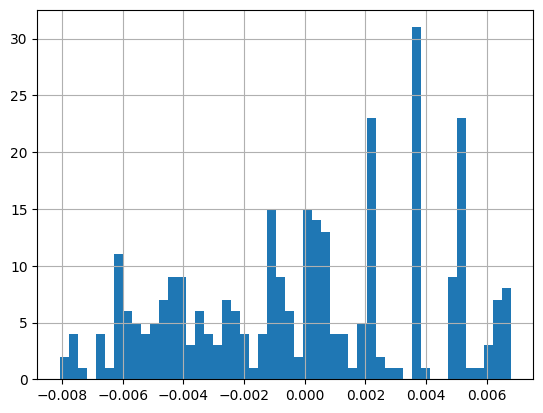

In [11]:
weights.iloc[-1].sort_values().hist(bins=50)

# Vol target

In [25]:
def vol_target_weights(raw_w: pd.DataFrame,
					   rets:   pd.DataFrame,
					   vol_target_ann: float,   # 10 % annualised
					   lookback: int,        # trading days
					   min_obs:  int      = 90) -> pd.DataFrame:
	"""
	Scale each day's weight vector so that realised σ ≈ `vol_target_ann`
	when estimated with a Ledoit-Wolf covariance on the past `lookback` days.

	Parameters
	----------
	raw_w            : DataFrame (index = timestamp, columns = symbol)
					   *pre-leverage* weights (dollar-neutral & |w|=1 already)
	rets             : DataFrame, same shape/order as `raw_w`
	vol_target_ann   : float, annualised target volatility (e.g. 0.10 = 10 %)
	lookback         : int, size of rolling window (calendar rows) for Σ̂
	min_obs          : int, minimum obs to start scaling; before that w = raw_w

	Returns
	-------
	scaled_w         : DataFrame of leverage-adjusted weights
	"""
	# daily target σ
	tgt_daily = vol_target_ann / np.sqrt(365)

	scaled = []
	for t, w in raw_w.iterrows():
		# slice past window *strictly up to and excluding* t
		end_loc = rets.index.get_loc(t)
		win = rets.iloc[max(0, end_loc - lookback): end_loc]
		win = win.dropna(axis=1, how="all").ffill()    

		if len(win) < min_obs:
			scaled.append(w)                     # not enough history yet
			continue

		# print date and fitting widow
		print(f"Vol target on {t.date()} using window "
			  f"{win.index[0].date()} to {win.index[-1].date()} "
			  f"({len(win)} obs, {len(win.columns)} assets)")

		# drop cols that are all-nan in window to keep LedoitWolf happy
		win = win.loc[:, win.notna().any()]

		# if every weight is zero (all skipped universe) just keep it
		if np.allclose(w, 0):
			scaled.append(w.reindex(raw_w.columns).fillna(0))
			continue

		# Ledoit–Wolf shrinkage; fall back if sklearn missing
		lw = LedoitWolf().fit(win.fillna(0))
		Sigma = lw.covariance_
		Sigma = pd.DataFrame(Sigma, index=win.columns, columns=win.columns)

		# align Σ to full column set, fill missing with zeros
		Sigma = Sigma.reindex(index=raw_w.columns, columns=raw_w.columns).fillna(0)

		# portfolio variance and scaling factor
		var_p = np.dot(w.values, np.dot(Sigma.values, w.values))
		if var_p <= 0:
			scale = 0.0
		else:
			scale = tgt_daily / np.sqrt(var_p)

		scaled.append(w * scale)

	scaled_w = pd.DataFrame(scaled, index=raw_w.index).fillna(0.0)
	return scaled_w


weights_scaled = vol_target_weights(weights, returns,
								vol_target_ann=0.1,
								lookback=180)

Vol target on 2021-06-30 using window 2021-04-01 to 2021-06-29 (90 obs, 93 assets)
Vol target on 2021-07-01 using window 2021-04-01 to 2021-06-30 (91 obs, 93 assets)
Vol target on 2021-07-02 using window 2021-04-01 to 2021-07-01 (92 obs, 93 assets)
Vol target on 2021-07-03 using window 2021-04-01 to 2021-07-02 (93 obs, 93 assets)
Vol target on 2021-07-04 using window 2021-04-01 to 2021-07-03 (94 obs, 93 assets)
Vol target on 2021-07-05 using window 2021-04-01 to 2021-07-04 (95 obs, 93 assets)
Vol target on 2021-07-06 using window 2021-04-01 to 2021-07-05 (96 obs, 93 assets)
Vol target on 2021-07-07 using window 2021-04-01 to 2021-07-06 (97 obs, 93 assets)
Vol target on 2021-07-08 using window 2021-04-01 to 2021-07-07 (98 obs, 94 assets)
Vol target on 2021-07-09 using window 2021-04-01 to 2021-07-08 (99 obs, 94 assets)
Vol target on 2021-07-10 using window 2021-04-01 to 2021-07-09 (100 obs, 94 assets)
Vol target on 2021-07-11 using window 2021-04-01 to 2021-07-10 (101 obs, 95 assets)
Vo

# Backtest

In [30]:
# PnL and turnover calculation
def backtest(weights: pd.DataFrame,
			 returns: pd.DataFrame,
			 funding: pd.DataFrame,
			 cost_rate: float):
	weights = weights.fillna(0)
	return_pnl = (weights * returns).sum(axis=1)
	funding_pnl = -(weights * funding).sum(axis=1)
	total = return_pnl + funding_pnl
	turnover = weights.fillna(0).diff().abs().sum(axis=1)
	total_after_cost = total - cost_rate * turnover
	return return_pnl, funding_pnl, total_after_cost, turnover

trading_cost_rate = 0

rtn_pnl, fnd_pnl, tot_pnl_post_cost, turn = backtest(weights, returns, funding, trading_cost_rate)

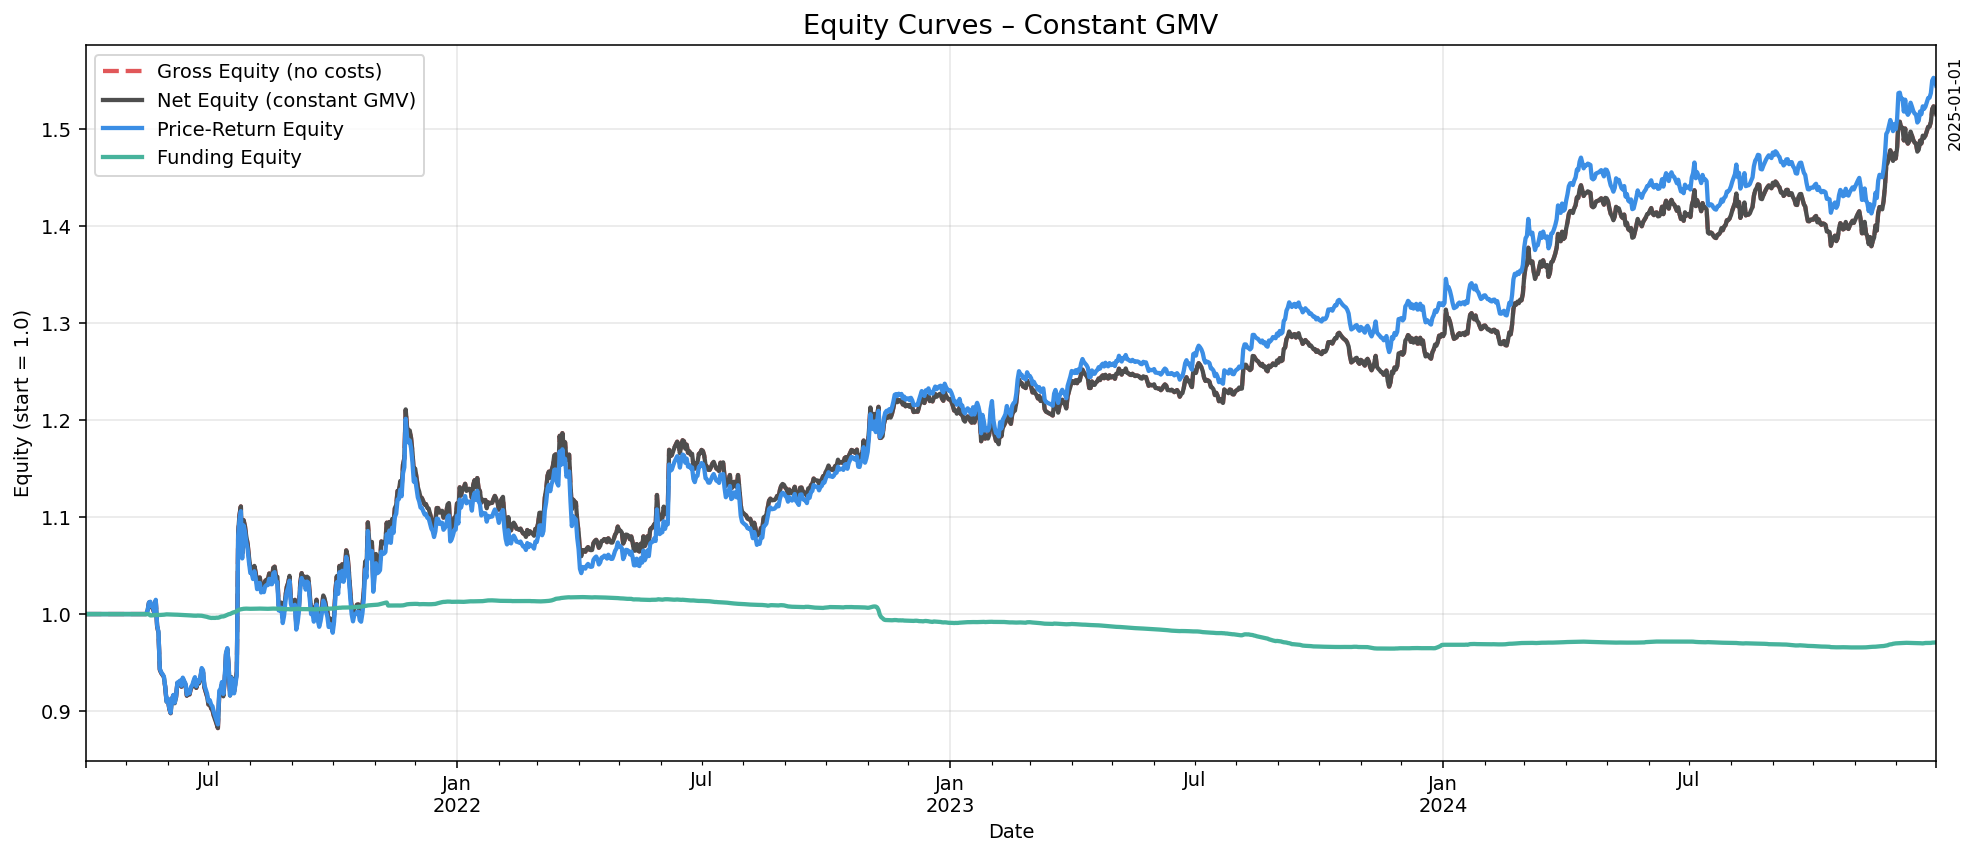

──────── Performance Summary ────────
CAGR:                           11.70%
Annualised volatility:           16.63%
Sharpe (ann.):                    0.82   95% CI [-0.35, 2.00]
Max drawdown:                  -15.13%
──────── Execution / Cost ───────────
Avg daily turnover:             16.21%
Avg holding period:               6.17 days
Average annual cost drag:          0.00 bp


In [31]:
def plot_results(return_pnl, funding_pnl, total_after_cost, *, highlight_date="2025-01-01"):
    # Build cumulative equity series (constant GMV, start = 1.0)
    gross_eq   = 1 + (return_pnl + funding_pnl).cumsum()
    total_eq   = 1 + total_after_cost.cumsum()
    return_eq  = 1 + return_pnl.cumsum()
    funding_eq = 1 + funding_pnl.cumsum()

    gross_eq.index   = pd.to_datetime(gross_eq.index)
    total_eq.index   = pd.to_datetime(total_eq.index)
    return_eq.index  = pd.to_datetime(return_eq.index)
    funding_eq.index = pd.to_datetime(funding_eq.index)

    # Fresh figure; constrained layout but no bbox-tight cropping
    plt.close('all')
    fig, ax = plt.subplots(figsize=(14, 6), dpi=140, constrained_layout=True)

    # Colors (Okabe–Ito-ish)
    palette = {
        "gross":   "#E15759",
        "net":     "#4E4E4E",
        "return":  "#3B8EE5",
        "funding": "#47B39C",
    }
    lw = 2.2

    gross_eq.plot(ax=ax, label="Gross Equity (no costs)",   lw=lw, ls="--", color=palette["gross"])
    total_eq.plot(ax=ax, label="Net Equity (constant GMV)", lw=lw,            color=palette["net"])
    return_eq.plot(ax=ax, label="Price-Return Equity",       lw=lw,            color=palette["return"])
    funding_eq.plot(ax=ax, label="Funding Equity",           lw=lw,            color=palette["funding"])

    # Optional vertical reference line (+ label kept INSIDE the axes)
    if highlight_date is not None:
        d = pd.to_datetime(highlight_date)
        ax.axvline(d, lw=1.6, ls=":", color="#6F6F6F", alpha=0.85, zorder=0)
        ax.annotate(
            d.strftime("%Y-%m-%d"),
            xy=(d, 1.0), xycoords=('data', 'axes fraction'),
            xytext=(5, -5), textcoords='offset points',
            rotation=90, va='top', ha='left', fontsize='small',
            annotation_clip=False   # don't clip, but stays in axes bbox
        )

    ax.set_title("Equity Curves – Constant GMV", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity (start = 1.0)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Ensure the full date range is used and give a little padding
    ax.set_xlim(min(gross_eq.index.min(), total_eq.index.min()),
                max(gross_eq.index.max(), total_eq.index.max()))
    ax.margins(x=0.01, y=0.05)

    plt.show()


# ── Expanded performance report ──────────────────────────────────────────────
def report_metrics(total_after_cost, return_pnl, turnover, cost_rate):
	"""
	Prints an extended performance summary.
	"""
	import numpy as np
	import pandas as pd

	# --- core statistics -----------------------------------------------------
	mu     = total_after_cost.mean()
	sigma  = return_pnl.std()
	sharpe = mu / sigma * np.sqrt(365)

	# 95 % CI on annualised Sharpe (Jobson & Korkie, 1981)
	n   = len(total_after_cost)
	se  = np.sqrt((1 + 0.5 * sharpe**2) * 365 / n)
	ci  = sharpe - 1.96 * se, sharpe + 1.96 * se

	# --- risk-adjusted extras -----------------------------------------------
	# annualised volatility
	vol_ann = sigma * np.sqrt(365) * 100

	# CAGR of the equity curve (constant-GMV arithmetic cum-P&L)
	equity_curve = 1 + total_after_cost.cumsum()
	cagr = equity_curve.iloc[-1]**(365 / n) - 1

	# max drawdown of cumulative P&L (not compounded)
	running_max = equity_curve.cummax()
	drawdown    = equity_curve - running_max
	max_dd      = drawdown.min()      # negative number

	# turnover & cost
	avg_turnover   = turnover.mean()
	avg_hold       = 1 / avg_turnover if avg_turnover else np.inf
	cost_pnl       = -cost_rate * turnover
	cost_drag_bps  = cost_pnl.mean() * 1e4* 365   # annual cost in bps

	# --- print nicely --------------------------------------------------------
	print("──────── Performance Summary ────────")
	print(f"CAGR:                          {cagr:7.2%}")
	print(f"Annualised volatility:         {vol_ann:7.2f}%")
	print(f"Sharpe (ann.):                 {sharpe:7.2f}   95% CI [{ci[0]:.2f}, {ci[1]:.2f}]")
	print(f"Max drawdown:                 {max_dd:8.2%}")
	print("──────── Execution / Cost ───────────")
	print(f"Avg daily turnover:            {avg_turnover:7.2%}")
	print(f"Avg holding period:            {avg_hold:7.2f} days")
	print(f"Average annual cost drag:       {cost_drag_bps:7.2f} bp")


plot_results(rtn_pnl, fnd_pnl, tot_pnl_post_cost)
report_metrics(tot_pnl_post_cost, rtn_pnl, turn, trading_cost_rate)